# Bayesian Neural Network


## The Model

The model is a small extention of Logistic Regression. In Logistic Regression the likelihood is a linear function of the prior. In a neural network, it is any (non-linear) function of the prior. 

$P(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \alpha^{-1}\mathbf{I})$

$P(\mathbf{y} \mid \mathbf{X}, \mathbf{w} ) = \sigma(\mathcal{N}(\mathbf{f(X,w)}, \beta^{-1}\mathbf{I}))$


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.datasets import make_classification
%matplotlib inline

In [2]:
a = torch.ones(200)
a[100:200].shape

torch.Size([100])

In [14]:
class BayesianNeuralNetworkELBO(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(BayesianNeuralNetworkELBO, self).__init__()
        self.hidden_size = 5
        self.l1_shape = (in_features, self.hidden_size)
        self.l2_shape = (self.hidden_size, out_features)
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x, w):
        n_l1 = self.l1_shape[0]*self.l1_shape[1]
        n_l2 =self.l2_shape[0]*self.l2_shape[1]
        
        w1 = w[:n_l1].view(self.l1_shape)
        w2 = w[n_l1:n_l1+n_l2].view(self.l2_shape)
        
        a1 = self.tanh(torch.matmul(x, w1))
        return torch.matmul(a1, w2)
    
    def forward_with_sigmoid(self, x, w):
        return self.sigmoid(self.forward(x,w))
    
    def loss(self, x, y, w, approx_mean, approx_chl_flat):
     
        y_hat = self.forward(x,w)
        app_cov = vec_to_ldiag(approx_chl_flat, 20)
        q_cov =torch.matmul(app_cov, app_cov.transpose(0,1))

        return self.bce(y_hat, y)-self.analytical_KLD(approx_mean, q_cov ,
                                                      torch.zeros_like(approx_mean), 
                                                      torch.eye(q_cov.shape[0]))/(x.shape[0]*x.shape[1])
        
        
    def analytical_KLD(self, m1, c1, m2, c2):
        
        trace = torch.trace(torch.matmul(torch.inverse(c2), c1))
        dmu = (m2 - m1).reshape(-1,1)
        mhlbs = torch.matmul(torch.matmul(dmu.transpose(0,1), torch.inverse(c2)), dmu)
        det_ratio = torch.log(torch.det(c2))-torch.log(torch.det(c1))
        return 0.5*(det_ratio+trace+mhlbs+c2.shape[0])

In [15]:
bnn = BayesianNeuralNetworkELBO(3,1)

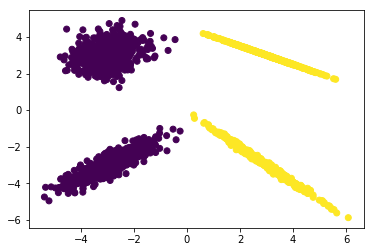

In [16]:
x, y = make_classification(n_samples=2000, flip_y=0, n_features=2, n_informative=2, n_redundant=0, class_sep=3.0)
plt.scatter(x[:,0], x[:,1], c=y)
x_1s = np.concatenate([np.ones((x.shape[0],1)), x], axis=1)

In [17]:
def vec_to_ldiag(vec, size):
    c = torch.zeros(size, size)
    c[torch.tril(torch.ones(size, size)) == 1] = vec
    c[torch.eye(size).byte()] = torch.nn.functional.sigmoid(c[torch.eye(size).byte()])
    return c

approx_mean = torch.nn.Parameter(torch.ones(20))
approx_cov_params = torch.nn.Parameter(torch.ones(210).float())

approx_chl = vec_to_ldiag(approx_cov_params, 20)


mvn = torch.distributions.MultivariateNormal(approx_mean, scale_tril=approx_chl)

opt = torch.optim.Adam([approx_mean, approx_cov_params], lr=0.05)

In [18]:
x_t = torch.autograd.Variable(torch.from_numpy(x_1s).float())
y_t = torch.autograd.Variable(torch.from_numpy(y.reshape(-1,1)).float())
for t in range(70000):
    opt.zero_grad()
    w=mvn.rsample()
    q_cov = vec_to_ldiag(approx_cov_params, 20)
    
    loss = bnn.loss(x_t,y_t, w, approx_mean, approx_cov_params)
    loss.backward(retain_graph=True)
    opt.step()

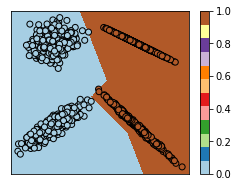

In [21]:
h=0.01
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xy_1s = np.c_[np.ones(len(xx.ravel())), xx.ravel(), yy.ravel()]

Z = bnn.forward_with_sigmoid(torch.from_numpy(xy_1s).float(), approx_mean).data.numpy()

# Put the result into a cololr plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.colorbar()
plt.show()

# Summary

In this post we have shown how we can use the ELBO to train a Bayesian neural network.